# Token Impact Analysis: HTML Preprocessing

This notebook analyzes the impact of HTML preprocessing on token counts for the CrawlerLM dataset.

**Goal**: Understand how removing CSS/JS noise affects:
1. Token counts (before vs after)
2. Signal-to-noise ratio
3. Whether examples fit within model context windows

In [1]:
import json
from pathlib import Path
from bs4 import BeautifulSoup
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Dataset

In [2]:
# Load test dataset (real, unaugmented examples)
test_path = Path("../data/processed/test_chat.jsonl")
train_path = Path("../data/processed/train_chat.jsonl")

def load_jsonl(path):
    with open(path) as f:
        return [json.loads(line) for line in f]

test_examples = load_jsonl(test_path)
train_examples = load_jsonl(train_path)

print(f"Test examples: {len(test_examples)}")
print(f"Train examples: {len(train_examples)}")

Test examples: 42
Train examples: 306


In [3]:
# Extract HTML from chat format
def extract_html_from_chat(example):
    """Extract HTML content from the user message."""
    user_msg = example["messages"][0]["content"]
    # HTML starts after "HTML:\n"
    html_start = user_msg.find("HTML:\n") + 6
    return user_msg[html_start:]

def extract_json_from_chat(example):
    """Extract expected JSON from the assistant message."""
    return example["messages"][1]["content"]

# Test extraction
sample_html = extract_html_from_chat(test_examples[0])
sample_json = extract_json_from_chat(test_examples[0])
print(f"Sample HTML length: {len(sample_html)} chars")
print(f"Sample JSON length: {len(sample_json)} chars")
print(f"\nFirst 500 chars of HTML:\n{sample_html[:500]}...")

Sample HTML length: 36748 chars
Sample JSON length: 2392 chars

First 500 chars of HTML:
<!DOCTYPE html>
<html lang="en-US" class="no-js">
<head>
	<meta charset="UTF-8">
	<meta name="viewport" content="width=device-width, initial-scale=1.0">
	<link rel="profile" href="https://gmpg.org/xfn/11">
		<script>(function(html){html.className = html.className.replace(/\bno-js\b/,'js')})(document.documentElement);</script>
<title>Uncategorized &#8211; My Blog</title>
<meta name='robots' content='index, max-snippet:-1, max-image-preview:large, max-video-preview:-1, follow' />
<meta name="googl...


## 2. Define Preprocessing Functions

In [4]:
def clean_html_minimal(html: str) -> str:
    """Minimal cleaning: Remove style and script tags only."""
    soup = BeautifulSoup(html, 'html.parser')
    
    # Remove style and script tags
    for tag in soup.find_all(['style', 'script', 'noscript']):
        tag.decompose()
    
    return str(soup)


def clean_html_moderate(html: str) -> str:
    """Moderate cleaning: Remove styles, scripts, and inline styles."""
    soup = BeautifulSoup(html, 'html.parser')
    
    # Remove style and script tags
    for tag in soup.find_all(['style', 'script', 'noscript', 'svg', 'path']):
        tag.decompose()
    
    # Remove inline styles
    for tag in soup.find_all(True):
        if 'style' in tag.attrs:
            del tag['style']
        # Remove class attributes (often just styling)
        if 'class' in tag.attrs:
            del tag['class']
    
    return str(soup)


def clean_html_aggressive(html: str) -> str:
    """Aggressive cleaning: Keep only semantic content."""
    soup = BeautifulSoup(html, 'html.parser')
    
    # Remove non-content tags
    for tag in soup.find_all(['style', 'script', 'noscript', 'svg', 'path', 
                              'link', 'meta', 'iframe', 'form', 'input',
                              'button', 'nav', 'footer', 'aside', 'header']):
        tag.decompose()
    
    # Remove all attributes except href, src, alt, title
    keep_attrs = {'href', 'src', 'alt', 'title', 'datetime', 'content'}
    for tag in soup.find_all(True):
        attrs_to_remove = [attr for attr in tag.attrs if attr not in keep_attrs]
        for attr in attrs_to_remove:
            del tag[attr]
    
    # Remove empty tags
    for tag in soup.find_all(True):
        if not tag.get_text(strip=True) and not tag.find_all(['img', 'a']):
            tag.decompose()
    
    return str(soup)

print("Preprocessing functions defined.")

Preprocessing functions defined.


## 3. Setup Tokenizer

In [5]:
# Use tiktoken for consistent token counting (cl100k_base is similar to many modern models)
# For exact Qwen3 tokenization, you'd use the HF tokenizer
enc = tiktoken.get_encoding("cl100k_base")

def count_tokens(text: str) -> int:
    """Count tokens using tiktoken."""
    return len(enc.encode(text))

# Test
print(f"Sample text token count: {count_tokens(sample_html)}")

Sample text token count: 11058


## 4. Analyze Token Impact

In [6]:
# Analyze all test examples
results = []

for i, example in enumerate(test_examples):
    html = extract_html_from_chat(example)
    expected_json = extract_json_from_chat(example)
    
    # Apply different preprocessing levels
    html_minimal = clean_html_minimal(html)
    html_moderate = clean_html_moderate(html)
    html_aggressive = clean_html_aggressive(html)
    
    # Count tokens
    results.append({
        'example_idx': i,
        'original_chars': len(html),
        'original_tokens': count_tokens(html),
        'minimal_chars': len(html_minimal),
        'minimal_tokens': count_tokens(html_minimal),
        'moderate_chars': len(html_moderate),
        'moderate_tokens': count_tokens(html_moderate),
        'aggressive_chars': len(html_aggressive),
        'aggressive_tokens': count_tokens(html_aggressive),
        'json_tokens': count_tokens(expected_json),
    })

df = pd.DataFrame(results)
df.head()

,example_idx,original_chars,original_tokens,minimal_chars,minimal_tokens,moderate_chars,moderate_tokens,aggressive_chars,aggressive_tokens,json_tokens
0,0,36748,11058,9269,2719,7385,2305,728,186,882
1,1,24331,7484,3569,968,3066,859,1287,327,326
2,2,48646,15665,16666,5888,10329,4485,1738,1100,949
3,3,23076,5135,13402,3460,10824,2877,6444,1600,947
4,4,28919,8935,22662,7470,21113,7118,12025,4147,3153


In [7]:
# Calculate reduction percentages
df['minimal_reduction_pct'] = (1 - df['minimal_tokens'] / df['original_tokens']) * 100
df['moderate_reduction_pct'] = (1 - df['moderate_tokens'] / df['original_tokens']) * 100
df['aggressive_reduction_pct'] = (1 - df['aggressive_tokens'] / df['original_tokens']) * 100

# Calculate signal-to-noise ratio (JSON tokens / HTML tokens)
df['original_snr'] = df['json_tokens'] / df['original_tokens']
df['minimal_snr'] = df['json_tokens'] / df['minimal_tokens']
df['moderate_snr'] = df['json_tokens'] / df['moderate_tokens']
df['aggressive_snr'] = df['json_tokens'] / df['aggressive_tokens']

df.describe()

,example_idx,original_chars,original_tokens,minimal_chars,minimal_tokens,moderate_chars,moderate_tokens,aggressive_chars,aggressive_tokens,json_tokens,minimal_reduction_pct,moderate_reduction_pct,aggressive_reduction_pct,original_snr,minimal_snr,moderate_snr,aggressive_snr
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,20.500000,31796.166667,8898.309524,18727.166667,6386.357143,13957.690476,4916.166667,7120.928571,2685.380952,2382.500000,25.929654,40.317726,66.143825,0.303867,0.397257,0.482364,1.308874
std,12.267844,25313.239447,4014.865368,11081.340684,3506.856127,8278.258918,2336.847866,6683.908264,2122.748850,1602.947213,22.693354,21.398204,21.974448,0.184535,0.199353,0.213348,1.740464
min,0.000000,8729.000000,4171.000000,3569.000000,968.000000,3066.000000,859.000000,728.000000,186.000000,326.000000,4.093390,8.260268,25.711140,0.039885,0.064518,0.096631,0.193182
25%,10.250000,17435.250000,5847.000000,11318.000000,3747.000000,7997.250000,3282.750000,2525.750000,1160.500000,987.500000,10.794817,22.605550,49.143358,0.144982,0.240060,0.292627,0.784870
50%,20.500000,23609.000000,7145.000000,16000.500000,5647.500000,11197.500000,4380.000000,5688.000000,2392.000000,2202.000000,16.415152,36.005005,63.897785,0.354456,0.420135,0.506621,0.896577
75%,30.750000,38851.750000,11630.250000,21618.750000,7250.500000,16992.000000,5851.750000,9228.500000,3550.000000,3285.750000,29.289295,53.117731,89.020406,0.440931,0.596440,0.664742,1.106565
max,41.000000,162783.000000,18196.000000,49020.000000,17096.000000,40265.000000,10221.000000,33060.000000,8155.000000,6883.000000,87.065740,88.522181,98.317960,0.712086,0.842748,0.896144,11.452656


## 5. Visualize Results

In [8]:
# Summary statistics
print("=" * 60)
print("TOKEN COUNT SUMMARY (Test Set)")
print("=" * 60)
print(f"\nOriginal HTML:")
print(f"  Mean tokens: {df['original_tokens'].mean():,.0f}")
print(f"  Median tokens: {df['original_tokens'].median():,.0f}")
print(f"  Min/Max: {df['original_tokens'].min():,} / {df['original_tokens'].max():,}")

print(f"\nMinimal Cleaning (remove <style>/<script>):")
print(f"  Mean tokens: {df['minimal_tokens'].mean():,.0f}")
print(f"  Mean reduction: {df['minimal_reduction_pct'].mean():.1f}%")

print(f"\nModerate Cleaning (+ inline styles/classes):")
print(f"  Mean tokens: {df['moderate_tokens'].mean():,.0f}")
print(f"  Mean reduction: {df['moderate_reduction_pct'].mean():.1f}%")

print(f"\nAggressive Cleaning (semantic only):")
print(f"  Mean tokens: {df['aggressive_tokens'].mean():,.0f}")
print(f"  Mean reduction: {df['aggressive_reduction_pct'].mean():.1f}%")

print(f"\nExpected JSON Output:")
print(f"  Mean tokens: {df['json_tokens'].mean():,.0f}")

TOKEN COUNT SUMMARY (Test Set)

Original HTML:
  Mean tokens: 8,898
  Median tokens: 7,145
  Min/Max: 4,171 / 18,196

Minimal Cleaning (remove <style>/<script>):
  Mean tokens: 6,386
  Mean reduction: 25.9%

Moderate Cleaning (+ inline styles/classes):
  Mean tokens: 4,916
  Mean reduction: 40.3%

Aggressive Cleaning (semantic only):
  Mean tokens: 2,685
  Mean reduction: 66.1%

Expected JSON Output:
  Mean tokens: 2,382


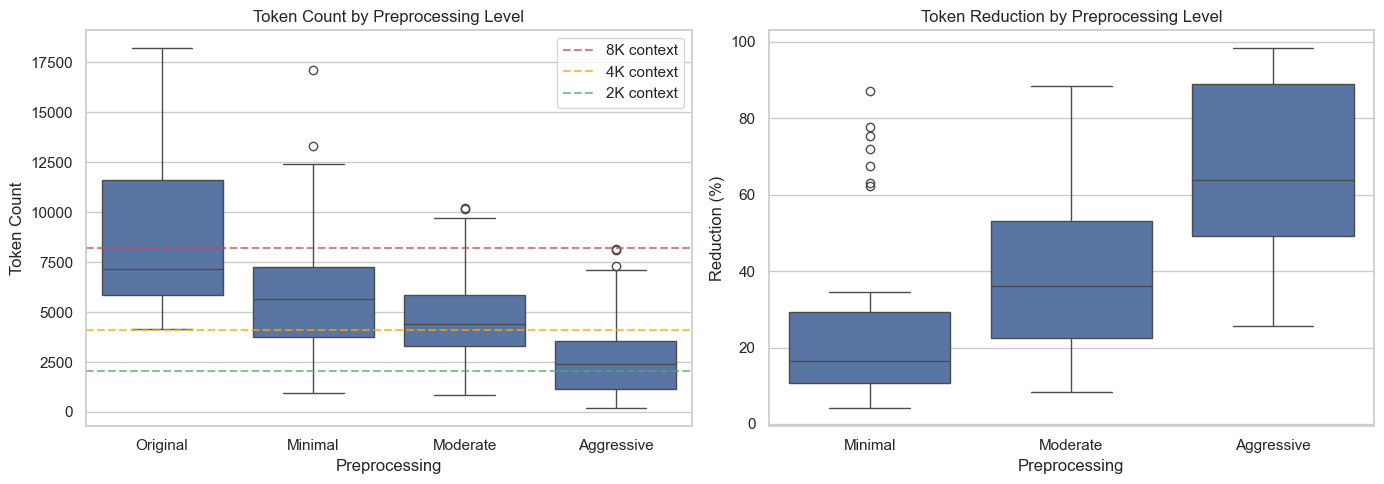

In [9]:
# Box plot of token counts by preprocessing level
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Token counts comparison
token_data = pd.melt(df[['original_tokens', 'minimal_tokens', 'moderate_tokens', 'aggressive_tokens']], 
                     var_name='Preprocessing', value_name='Tokens')
token_data['Preprocessing'] = token_data['Preprocessing'].map({
    'original_tokens': 'Original',
    'minimal_tokens': 'Minimal',
    'moderate_tokens': 'Moderate',
    'aggressive_tokens': 'Aggressive'
})

sns.boxplot(data=token_data, x='Preprocessing', y='Tokens', ax=axes[0], 
            order=['Original', 'Minimal', 'Moderate', 'Aggressive'])
axes[0].set_title('Token Count by Preprocessing Level')
axes[0].set_ylabel('Token Count')

# Add context window lines
axes[0].axhline(y=8192, color='r', linestyle='--', alpha=0.7, label='8K context')
axes[0].axhline(y=4096, color='orange', linestyle='--', alpha=0.7, label='4K context')
axes[0].axhline(y=2048, color='g', linestyle='--', alpha=0.7, label='2K context')
axes[0].legend()

# Reduction percentage
reduction_data = pd.melt(df[['minimal_reduction_pct', 'moderate_reduction_pct', 'aggressive_reduction_pct']], 
                         var_name='Preprocessing', value_name='Reduction %')
reduction_data['Preprocessing'] = reduction_data['Preprocessing'].map({
    'minimal_reduction_pct': 'Minimal',
    'moderate_reduction_pct': 'Moderate',
    'aggressive_reduction_pct': 'Aggressive'
})

sns.boxplot(data=reduction_data, x='Preprocessing', y='Reduction %', ax=axes[1],
            order=['Minimal', 'Moderate', 'Aggressive'])
axes[1].set_title('Token Reduction by Preprocessing Level')
axes[1].set_ylabel('Reduction (%)')

plt.tight_layout()
plt.show()

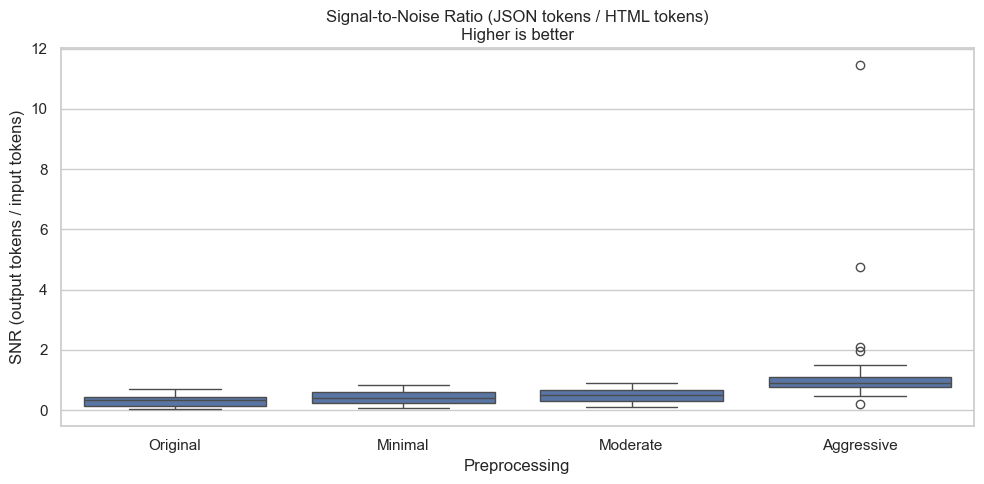


Signal-to-Noise Ratio Summary:
  Original: 0.3039 (1 output token per 3 input tokens)
  Minimal:  0.3973 (1 output token per 3 input tokens)
  Moderate: 0.4824 (1 output token per 2 input tokens)
  Aggressive: 1.3089 (1 output token per 1 input tokens)


In [10]:
# Signal-to-Noise Ratio comparison
fig, ax = plt.subplots(figsize=(10, 5))

snr_data = pd.melt(df[['original_snr', 'minimal_snr', 'moderate_snr', 'aggressive_snr']], 
                   var_name='Preprocessing', value_name='SNR')
snr_data['Preprocessing'] = snr_data['Preprocessing'].map({
    'original_snr': 'Original',
    'minimal_snr': 'Minimal',
    'moderate_snr': 'Moderate',
    'aggressive_snr': 'Aggressive'
})

sns.boxplot(data=snr_data, x='Preprocessing', y='SNR', 
            order=['Original', 'Minimal', 'Moderate', 'Aggressive'])
ax.set_title('Signal-to-Noise Ratio (JSON tokens / HTML tokens)\nHigher is better')
ax.set_ylabel('SNR (output tokens / input tokens)')

plt.tight_layout()
plt.show()

print("\nSignal-to-Noise Ratio Summary:")
print(f"  Original: {df['original_snr'].mean():.4f} (1 output token per {1/df['original_snr'].mean():.0f} input tokens)")
print(f"  Minimal:  {df['minimal_snr'].mean():.4f} (1 output token per {1/df['minimal_snr'].mean():.0f} input tokens)")
print(f"  Moderate: {df['moderate_snr'].mean():.4f} (1 output token per {1/df['moderate_snr'].mean():.0f} input tokens)")
print(f"  Aggressive: {df['aggressive_snr'].mean():.4f} (1 output token per {1/df['aggressive_snr'].mean():.0f} input tokens)")

In [11]:
# Examples fitting within context windows
context_windows = [1024, 2048, 4096, 8192, 16384, 32768]

fit_stats = []
for ctx in context_windows:
    fit_stats.append({
        'Context Window': f'{ctx:,}',
        'Original': (df['original_tokens'] <= ctx).sum(),
        'Minimal': (df['minimal_tokens'] <= ctx).sum(),
        'Moderate': (df['moderate_tokens'] <= ctx).sum(),
        'Aggressive': (df['aggressive_tokens'] <= ctx).sum(),
    })

fit_df = pd.DataFrame(fit_stats)
print("\nExamples fitting within context window (out of", len(df), "total):")
print(fit_df.to_string(index=False))


Examples fitting within context window (out of 42 total):
Context Window  Original  Minimal  Moderate  Aggressive
         1,024         0        1         1           9
         2,048         0        1         2          20
         4,096         0       14        19          35
         8,192        23       33        35          42
        16,384        39       41        42          42
        32,768        42       42        42          42


## 6. Detailed Example Comparison

In [12]:
# Show a detailed example
example_idx = 0
example = test_examples[example_idx]

html = extract_html_from_chat(example)
html_minimal = clean_html_minimal(html)
html_moderate = clean_html_moderate(html)
html_aggressive = clean_html_aggressive(html)

print(f"Example {example_idx}:")
print(f"  Original: {count_tokens(html):,} tokens ({len(html):,} chars)")
print(f"  Minimal:  {count_tokens(html_minimal):,} tokens ({len(html_minimal):,} chars)")
print(f"  Moderate: {count_tokens(html_moderate):,} tokens ({len(html_moderate):,} chars)")
print(f"  Aggressive: {count_tokens(html_aggressive):,} tokens ({len(html_aggressive):,} chars)")

print("\n" + "="*60)
print("AGGRESSIVE CLEANED HTML (first 2000 chars):")
print("="*60)
print(html_aggressive[:2000])

Example 0:
  Original: 11,058 tokens (36,748 chars)
  Minimal:  2,719 tokens (9,269 chars)
  Moderate: 2,305 tokens (7,385 chars)
  Aggressive: 186 tokens (728 chars)

AGGRESSIVE CLEANED HTML (first 2000 chars):
<!DOCTYPE html>

<html>
<head>




<title>Uncategorized – My Blog</title>
</head>
<body>
<div>
<div>
<a href="#content">
			Skip to content		</a>
<!-- .site-header -->
<div>
<div>
<main>
<!-- .page-header -->
<article>
<!-- .entry-header -->
<div>
<p>Welcome to WordPress. This is your first post. Edit or delete it, then start writing!</p>
</div><!-- .entry-content -->
<!-- .entry-footer -->
</article><!-- #post-1 -->
</main><!-- .site-main -->
</div><!-- .content-area -->
<!-- .sidebar .widget-area -->
</div><!-- .site-content -->
<!-- .site-footer -->
</div><!-- .site-inner -->
</div><!-- .site -->



</body>
</html>


Return a JSON object with these fields: url, title, text, author, published_date, image, favicon, id


In [13]:
# What's being removed? Analyze tag distribution
from collections import Counter

def get_tag_distribution(html: str) -> Counter:
    soup = BeautifulSoup(html, 'html.parser')
    return Counter(tag.name for tag in soup.find_all(True))

original_tags = get_tag_distribution(html)
aggressive_tags = get_tag_distribution(html_aggressive)

print("Top 15 tags in ORIGINAL HTML:")
for tag, count in original_tags.most_common(15):
    print(f"  {tag}: {count}")

print("\nTop 15 tags in AGGRESSIVE cleaned HTML:")
for tag, count in aggressive_tags.most_common(15):
    print(f"  {tag}: {count}")

Top 15 tags in ORIGINAL HTML:
  a: 46
  br: 34
  meta: 16
  div: 14
  style: 13
  link: 12
  script: 9
  span: 9
  p: 4
  section: 4
  header: 3
  h2: 3
  footer: 3
  article: 2
  li: 2

Top 15 tags in AGGRESSIVE cleaned HTML:
  div: 5
  html: 1
  head: 1
  title: 1
  body: 1
  a: 1
  main: 1
  article: 1
  p: 1


## 7. Train Set Analysis

In [14]:
# Quick analysis of training set (sample for speed)
train_sample = train_examples[:50]  # Sample first 50

train_results = []
for i, example in enumerate(train_sample):
    html = extract_html_from_chat(example)
    html_moderate = clean_html_moderate(html)
    
    train_results.append({
        'original_tokens': count_tokens(html),
        'moderate_tokens': count_tokens(html_moderate),
    })

train_df = pd.DataFrame(train_results)
train_df['reduction_pct'] = (1 - train_df['moderate_tokens'] / train_df['original_tokens']) * 100

print("TRAIN SET SAMPLE (50 examples):")
print(f"  Original mean tokens: {train_df['original_tokens'].mean():,.0f}")
print(f"  Moderate mean tokens: {train_df['moderate_tokens'].mean():,.0f}")
print(f"  Mean reduction: {train_df['reduction_pct'].mean():.1f}%")

TRAIN SET SAMPLE (50 examples):
  Original mean tokens: 8,439
  Moderate mean tokens: 5,170
  Mean reduction: 33.6%


## 8. Recommendations

In [15]:
print("="*60)
print("RECOMMENDATIONS")
print("="*60)

# Calculate key stats
orig_mean = df['original_tokens'].mean()
mod_mean = df['moderate_tokens'].mean()
mod_reduction = df['moderate_reduction_pct'].mean()
orig_snr = df['original_snr'].mean()
mod_snr = df['moderate_snr'].mean()

print(f"""
1. PREPROCESSING IMPACT:
   - Moderate cleaning reduces tokens by ~{mod_reduction:.0f}%
   - From {orig_mean:,.0f} → {mod_mean:,.0f} average tokens
   - SNR improves from {orig_snr:.4f} → {mod_snr:.4f} ({mod_snr/orig_snr:.1f}x better)

2. CONTEXT WINDOW REQUIREMENTS:
   - Original: Need {df['original_tokens'].quantile(0.95):,.0f} tokens for 95% of examples
   - Moderate: Need {df['moderate_tokens'].quantile(0.95):,.0f} tokens for 95% of examples
   - Current training uses MAX_SEQ_LENGTH=1024 (too small!)

3. SUGGESTED CHANGES:
   a) Apply moderate HTML cleaning before training
   b) Increase MAX_SEQ_LENGTH to at least {int(df['moderate_tokens'].quantile(0.95)):,}
   c) Improve prompt with explicit JSON schema
   d) Consider aggressive cleaning if context is still an issue

4. TOKEN BUDGET (for 8K context):
   - System prompt: ~100 tokens
   - Schema description: ~150 tokens
   - HTML input: ~{mod_mean:,.0f} tokens (moderate cleaned)
   - JSON output: ~{df['json_tokens'].mean():,.0f} tokens
   - Total: ~{100 + 150 + mod_mean + df['json_tokens'].mean():,.0f} tokens
   - Fits comfortably in 8K context
""")

RECOMMENDATIONS

1. PREPROCESSING IMPACT:
   - Moderate cleaning reduces tokens by ~40%
   - From 8,898 → 4,916 average tokens
   - SNR improves from 0.3039 → 0.4824 (1.6x better)

2. CONTEXT WINDOW REQUIREMENTS:
   - Original: Need 16,585 tokens for 95% of examples
   - Moderate: Need 9,649 tokens for 95% of examples
   - Current training uses MAX_SEQ_LENGTH=1024 (too small!)

3. SUGGESTED CHANGES:
   a) Apply moderate HTML cleaning before training
   b) Increase MAX_SEQ_LENGTH to at least 9,648
   c) Improve prompt with explicit JSON schema
   d) Consider aggressive cleaning if context is still an issue

4. TOKEN BUDGET (for 8K context):
   - System prompt: ~100 tokens
   - Schema description: ~150 tokens
   - HTML input: ~4,916 tokens (moderate cleaned)
   - JSON output: ~2,382 tokens
   - Total: ~7,549 tokens
   - Fits comfortably in 8K context ✓



In [16]:
# Save analysis results
output_path = Path("../data/processed/token_analysis.csv")
df.to_csv(output_path, index=False)
print(f"Analysis saved to {output_path}")

Analysis saved to ../data/processed/token_analysis.csv
